In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

/Users/edward/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2624,-117.7,33.6,16.0,5175.0,799.0,2717.0,813.0,6.1,257800.0
5183,-118.1,33.9,35.0,1458.0,261.0,686.0,236.0,3.9,202700.0
13071,-121.9,37.3,39.0,2479.0,541.0,1990.0,506.0,2.4,289100.0
10528,-120.4,35.0,43.0,2020.0,344.0,692.0,310.0,3.7,181800.0
2230,-117.4,34.0,38.0,1383.0,238.0,649.0,232.0,5.0,148900.0
...,...,...,...,...,...,...,...,...,...
171,-116.2,33.7,5.0,1664.0,444.0,907.0,374.0,2.8,92900.0
3818,-117.9,33.8,33.0,2964.0,747.0,2235.0,718.0,3.3,175900.0
536,-117.0,34.9,34.0,2194.0,519.0,1326.0,515.0,2.1,72000.0
16728,-122.9,38.4,36.0,1987.0,387.0,1065.0,347.0,4.0,172200.0


In [4]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

In [5]:
def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [6]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2628.2,537.8,1424.7,500.1,3.9,2.0
std,2.1,2.0,12.6,2143.5,418.1,1154.2,382.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1459.0,296.8,784.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2113.0,434.0,1164.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3143.2,646.0,1711.0,601.2,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2680.8,543.3,1441.2,504.0,3.9,2.0
std,2.1,2.0,12.6,2264.9,429.6,1132.6,390.4,1.9,1.0
min,32.5,-124.3,2.0,11.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.7,18.0,1467.0,297.0,799.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2166.5,434.0,1176.5,409.0,3.6,2.0
75%,37.7,-118.0,37.0,3165.2,653.0,1744.8,611.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,29.4


Training targets summary:


,median_house_value
count,12000.0
mean,207.1
std,115.5
min,15.0
25%,119.4
50%,180.6
75%,264.1
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.9
std,117.1
min,15.0
25%,119.9
50%,179.5
75%,267.4
max,500.0


In [7]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
  
    Args:
      learning_rate: A `float`, the learning rate.
      steps: A non-zero `int`, the total number of training steps. A training step
        consists of a forward and backward pass using a single batch.
      feature_columns: A `set` specifying the input feature columns to use.
      training_examples: A `DataFrame` containing one or more columns from
        `california_housing_dataframe` to use as input features for training.
      training_targets: A `DataFrame` containing exactly one column from
        `california_housing_dataframe` to use as target for training.
      validation_examples: A `DataFrame` containing one or more columns from
        `california_housing_dataframe` to use as input features for validation.
      validation_targets: A `DataFrame` containing exactly one column from
        `california_housing_dataframe` to use as target for validation.
      
    Returns:
      A `LinearRegressor` object trained on the training data.
    """
  
    periods = 10
    steps_per_period = steps / periods
    
    # Create a linear regressor object
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer)
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"],
                                           batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"],
                                                   num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"],
                                                     num_epochs=1, shuffle=False)
    
    # Train the model inside a loop and periodically access loss metrics
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # Train the model, starting from the prior state
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
     # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 194.28
  period 01 : 480.62
  period 02 : 329.57
  period 03 : 349.98
  period 04 : 287.86
  period 05 : 269.14
  period 06 : 273.39
  period 07 : 234.26
  period 08 : 212.46
  period 09 : 220.50
Model training finished.


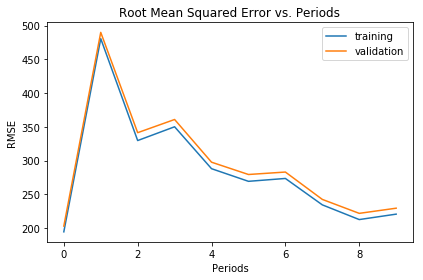

In [11]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [15]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundries)
    return [quantiles[q] for q in quantiles.keys()]

In [21]:
boundries = np.arange(1.0, 7) / 7
print('boundries', boundries)
quantiles = california_housing_dataframe["households"].quantile(boundries)
print('quantiles', quantiles)
for q in quantiles.keys():
    print('q', q)
    print('quantile[q]', quantiles[q])
    

boundries [0.14285714 0.28571429 0.42857143 0.57142857 0.71428571 0.85714286]
quantiles 0.1   220.0
0.3   300.0
0.4   371.0
0.6   451.0
0.7   567.0
0.9   769.0
Name: households, dtype: float64
q 0.14285714285714285
quantile[q] 220.0
q 0.2857142857142857
quantile[q] 300.0
q 0.42857142857142855
quantile[q] 371.0
q 0.5714285714285714
quantile[q] 451.0
q 0.7142857142857143
quantile[q] 567.0
q 0.8571428571428571
quantile[q] 769.0


In [22]:
# Divide households into 7 buckets
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(households, 
    boundaries=get_quantile_based_boundaries(california_housing_dataframe["households"], 7))

# Divide households into 10 buckets
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(longitude, 
    boundaries=get_quantile_based_boundaries(california_housing_dataframe["longitude"], 10))

In [23]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 168.89
  period 01 : 142.48
  period 02 : 125.96
  period 03 : 114.88
  period 04 : 107.05
  period 05 : 101.32
  period 06 : 96.97
  period 07 : 93.43
  period 08 : 90.55
  period 09 : 88.23
Model training finished.


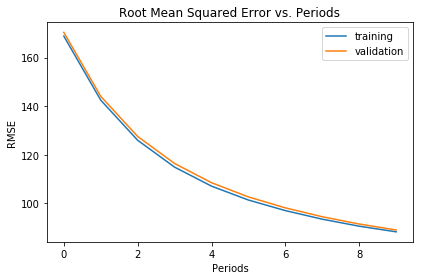

In [24]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [25]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 163.03
  period 01 : 134.87
  period 02 : 117.87
  period 03 : 106.65
  period 04 : 98.86
  period 05 : 93.14
  period 06 : 88.67
  period 07 : 85.14
  period 08 : 82.28
  period 09 : 79.97
Model training finished.


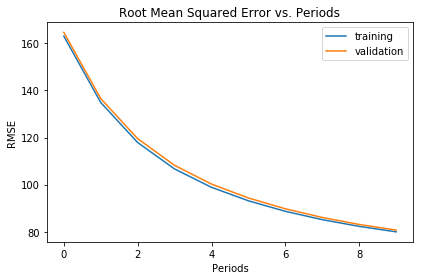

In [26]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)